In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import scipy.io
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from prettytable import PrettyTable
import copy

In [2]:
gpu_id = 2
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:2


In [3]:
# ------------------------- Load Data ------------------------- #
def load_data():
    data = scipy.io.loadmat("data/cylinder_nektar_wake.mat")

    # X_star: (5000, 2)
    x = data["X_star"][:, 0:1]
    y = data["X_star"][:, 1:2]

    # t: (200, 1)
    t = data["t"]

    # U_star: (5000, 2, 200)
    exact_u = data["U_star"][:, 0, :]
    exact_v = data["U_star"][:, 1, :]

    # p_star: (5000, 200)
    exact_p = data["p_star"]

    data.update({"x": x,
                 "y": y,
                 "exact_u": exact_u,
                 "exact_v": exact_v,
                 "exact_p": exact_p})

    return data

data = load_data()

In [4]:
# ------------------------- Model ------------------------- #
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_residual=True):
        super().__init__()
        self.use_residual = use_residual

        self.activation = nn.Tanh()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)

    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)

        if self.use_residual:
            out = out + x

        out = self.activation(out)
        return out

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, use_residual=True):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
        )

        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, use_residual) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

# ------------------------- Gradients ------------------------- #
def gradient(y: torch.Tensor, inputs: List[torch.Tensor]) -> List[torch.Tensor]:
    grads = torch.autograd.grad(
        outputs=y,
        inputs=inputs,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )
    return list(grads)


In [5]:
def count_parameters(model):
    # Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [6]:
def loss_fn(model, data):

    t = data[:, 0:1].clone().detach().requires_grad_(True)
    x = data[:, 1:2].clone().detach().requires_grad_(True)
    y = data[:, 2:3].clone().detach().requires_grad_(True)
    exact_u = data[:, 3:4]
    exact_v = data[:, 4:5]

    inputs = torch.cat([t, x, y], dim=1)

    outputs = {"t": t,
           "x": x,
           "y": y,
           "exact_u": exact_u,
           "exact_v": exact_v,}


    pred = model(inputs)

    psi = pred[:, 0:1]
    pressure = pred[:, 1:2]

    outputs.update({"psi": psi,
                    "pressure": pressure})

    output_mse, outputs = output_loss(outputs)
    pde_mse, outputs = pde_loss(model, outputs)

    total_mse = output_mse + pde_mse
    return output_mse, pde_mse, total_mse


def output_loss(outputs):

    x = outputs["x"]
    y = outputs["y"]
    exact_u = outputs["exact_u"]
    exact_v = outputs["exact_v"]

    psi = outputs["psi"]

    outputs["u"] = gradient(psi, [y])[0]
    outputs["v"] = -gradient(psi, [x])[0]

    mse_u = torch.mean((outputs["u"] - exact_u)**2)
    mse_v = torch.mean((outputs["v"] - exact_v)**2)

    output_mse = mse_u + mse_v

    return output_mse, outputs

def pde_loss(model, outputs):

    t = outputs["t"]
    x = outputs["x"]
    y = outputs["y"]

    u = outputs["u"]
    v = outputs["v"]
    p = outputs["pressure"]

    l1 = model.lambda1
    l2 = model.lambda2

    u_x, u_y, u_t = gradient(u, [x, y, t])
    v_x, v_y, v_t = gradient(v, [x, y, t])
    u_xx = gradient(u_x, [x])[0]
    u_yy = gradient(u_y, [y])[0]
    v_xx = gradient(v_x, [x])[0]
    v_yy = gradient(v_y, [y])[0]
    p_x, p_y = gradient(p, [x, y])

    outputs["f_u"] = u_t + l1 * (u * u_x + v * u_y) + p_x - l2 * (u_xx + u_yy)
    outputs["f_v"] = v_t + l1 * (u * v_x + v * v_y) + p_y - l2 * (v_xx + v_yy)

    pde_mse = torch.mean(outputs["f_u"]**2 + outputs["f_v"]**2)

    return pde_mse, outputs


In [7]:
class PinnResult:
    def __init__(self, model):
        self.model = model
        self.output_mse_log = []
        self.pde_mse_log = []
        self.total_mse_log = []

        self.valid_mse_log = []

        self.all_data = None
        self.training_data = None


# ------------------------- Training ------------------------- #
def train(max_epochs=1000):

    data = load_data()

    # ------- Format the NS training data into a single tensor -------
    N, T = data["exact_u"].shape    # N = 5000, T = 200

    # np.tile: construct an array by repeating A the number of times given by reps.
    x_tiled = np.tile(data["x"], (T, 1))
    y_tiled = np.tile(data["y"], (T, 1))

    t_repeated = np.repeat(data["t"].flatten(), N).reshape(-1, 1)  # (N*T, 1)

    u_flat = data["exact_u"].T.flatten().reshape(-1, 1)  # (N*T, 1)
    v_flat = data["exact_v"].T.flatten().reshape(-1, 1)  # (N*T, 1)
    p_flat = data["p_star"].T.flatten().reshape(-1, 1)

    all_data = np.hstack((t_repeated, x_tiled, y_tiled, u_flat, v_flat, p_flat))
    all_data = torch.tensor(all_data, dtype=torch.float32).to(device)

    n_samples = 5_000
    rand_id = torch.randperm(all_data.shape[0])[:n_samples]
    training_data = all_data[rand_id]
    #
    # # Model + optimizer
    # # model = PINN(in_dim=2, out_dim=2, width=64, depth=4)
    model = PINN(input_dim=3, hidden_dim=100, output_dim=2, num_blocks=7, use_residual=True).to(device)

    model.lambda1 = nn.Parameter(torch.tensor(0.0))
    model.lambda2 = nn.Parameter(torch.tensor(0.0))

    pinn_result = PinnResult(model)
    pinn_result.all_data = all_data
    pinn_result.training_data = training_data

    # Generate validation data
    n_samples = 5_000
    indices = torch.randperm(all_data.shape[0])[:n_samples]
    valid_data = all_data[indices]
    pinn_result.validation_data = valid_data

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    count_parameters(model)

    # Training loop
    for epoch in range(max_epochs):
        optimizer.zero_grad()

        output_loss, pde_loss, mse_loss = loss_fn(model, training_data)

        pinn_result.output_mse_log.append(output_loss.item())
        pinn_result.pde_mse_log.append(pde_loss.item())
        pinn_result.total_mse_log.append(mse_loss.item())

        _, _, valid_mse = loss_fn(model, valid_data)
        pinn_result.valid_mse_log.append(valid_mse.item())

        mse_loss.backward()

        # if using ADAM
        optimizer.step()

        # If using LBFGS
        # optimizer.step(closure)

        # loss_ic_log[epoch] = loss_data.item()
        # loss_pde_log[epoch] = loss_phys.item()

        if epoch % 10 == 0 or epoch == max_epochs-1:

            # mse_u, mse_v = evaluate_mse(model, data)
            # mse_val = mse_u + mse_v
            # loss_val_log[epoch] = mse_val.item()

            # print(f"[{epoch:05d}] loss= {loss.item():.4e} | ic= {loss_data.item():.4e} | pde= {loss_phys.item():.4e} | valid= {mse_val:.4e}")
            print(f"[{epoch:05d}] loss= {mse_loss.item():.4e}  |  valid= {valid_mse.item():.4e}")

    return pinn_result

pinn_result = train(max_epochs=20_000)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|         lambda1         |     1      |
|         lambda2         |     1      |
|   input_layer.0.weight  |    300     |
|    input_layer.0.bias   |    100     |
| blocks.0.linear1.weight |   10000    |
|  blocks.0.linear1.bias  |    100     |
| blocks.0.linear2.weight |   10000    |
|  blocks.0.linear2.bias  |    100     |
| blocks.1.linear1.weight |   10000    |
|  blocks.1.linear1.bias  |    100     |
| blocks.1.linear2.weight |   10000    |
|  blocks.1.linear2.bias  |    100     |
| blocks.2.linear1.weight |   10000    |
|  blocks.2.linear1.bias  |    100     |
| blocks.2.linear2.weight |   10000    |
|  blocks.2.linear2.bias  |    100     |
| blocks.3.linear1.weight |   10000    |
|  blocks.3.linear1.bias  |    100     |
| blocks.3.linear2.weight |   10000    |
|  blocks.3.linear2.bias  |    100     |
| blocks.4.linear1.weight |   10000    |
|  blocks.4.line

In [8]:
input = pinn_result.all_data

# Say you want to sample 100 random rows
n_samples = 20_000
indices = torch.randperm(input.shape[0])[:n_samples]
sample = input[indices]

output_mse, pde_mse, total_mse = loss_fn(pinn_result.model, sample)
print(f"output mse= {output_mse:.4e}")

output mse= 2.5191e-04


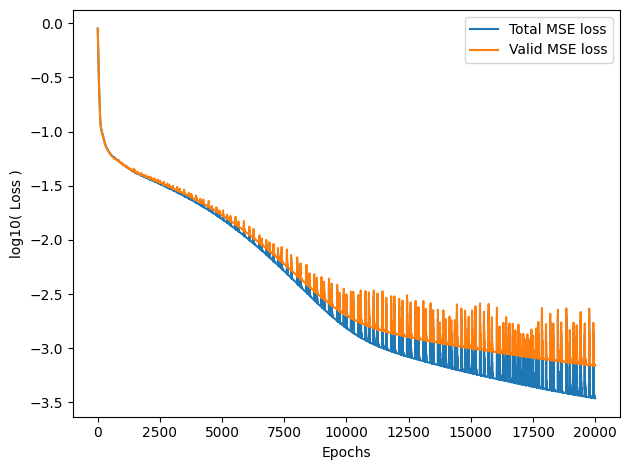

In [9]:
# loss_pde_log[0] = np.nan
# loss_val_log[0] = np.nan
#
#
fig, ax = plt.subplots(dpi=100, layout="tight")
ax.plot(np.log10(pinn_result.total_mse_log), label="Total MSE loss")
ax.plot(np.log10(pinn_result.valid_mse_log), label="Valid MSE loss")
# ax.plot(loss_val_log, label="Val loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("log10( Loss )")
ax.legend()

plt.savefig("ns_loss_v2.png", dpi=200)


l1= 0.9935  |  l2= 0.0113


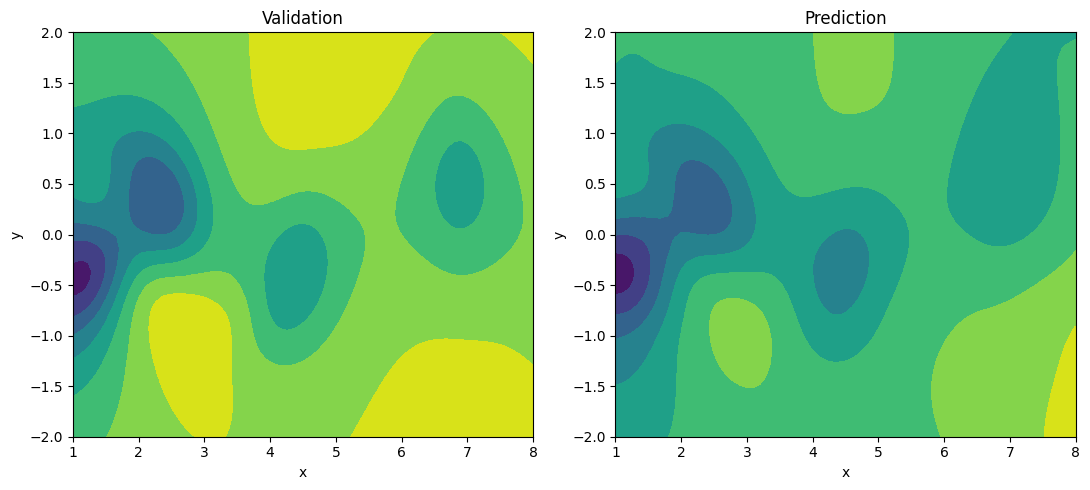

In [10]:

print(f"l1= {pinn_result.model.lambda1.item():.4f}  |  l2= {pinn_result.model.lambda2.item():.4f}")

all_data = copy.deepcopy(pinn_result.all_data)
training_data = copy.deepcopy(pinn_result.training_data)


all_data = all_data.cpu().detach().numpy()

mask = (all_data[:, 0] == 0)
masked_data = all_data[mask]

with torch.no_grad():

    input = np.hstack((masked_data[:, 0:1], masked_data[:, 1:2], masked_data[:, 2:3]))
    input = torch.tensor(input, dtype=torch.float32).to(device)
    pred = pinn_result.model(input)

fig, ax = plt.subplots(1, 2, figsize=(11, 5), dpi=100, layout="tight")

# ax.scatter(masked_data[:, 1], masked_data[:, 2])
ax[0].tricontourf(masked_data[:, 1], masked_data[:, 2], masked_data[:, -1])
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Validation")

ax[1].tricontourf(masked_data[:, 1], masked_data[:, 2], pred[:, 1].cpu().detach().numpy())
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Prediction")

plt.savefig("ns_pressure_field_v2.png", dpi=200)